<img src="https://github.com/rodolso/DS_Online_Octubre24/blob/main/05_Deep_Learning/Sprint_19/Unidad_01_IA_Generativa_Imagenes/img/cabecera.png?raw=1">

## Una (muy) breve introducción a la IA Generativa en Imágenes

## Setup

Vamos a emplear colab así, que allí nos vamos...

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rodolso/DS_Online_Octubre24/blob/main/05_Deep_Learning/Sprint_19/Unidad_01_IA_Generativa_Imagenes/Breve_Intro_a_Generativa_en_Imagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

Montamos Drive, o lo intentamos:

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


Comprobamos la versión de Python

In [3]:
import sys

assert sys.version_info >= (3, 7)

Comprobamos la versión de sklearn ≥ 1.0.1:

In [4]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

y de TensorFlow ≥ 2.8:

In [5]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

Algunos ajustes para cuando lancemos nuestro entrenamiento de redes GAN

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from time import time, sleep


plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Comprobación de si tenemos GPU a mano, porque si no ya te puedes ir a tomar un desayuno, comida o cena.

In [7]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

In [8]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.1
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
#@markdown Chequea el tipo de GPU y la memoria virtual disponible
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

NVIDIA GeForce RTX 2050, 4096 MiB, 3965 MiB


Utilizaremos el FMNIST, ese gran amigo nuestro de ropas y complementos

In [10]:
# extra code – loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Y un poco de código para poder pintar las imágenes:

In [11]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Lo primero un poco de historia sobre las redes generativas, principalmente de imágenes. Todo empieza cuando queremos encontrar representaciones de las imágenes denominadas "latentes" (es decir, reducidas y compactas):

* **Autoencoders**
* **GANs** (Generative Adversarial Networks)
* **Diffusion** (o más correctamente DDPM, Denoising Diffusion Probabilistic Model, que entrenados con condicionamiento de texto dan lugar a: Stable XL, Midjourney, DALL-E, etc)



## Autoencoders

Son **redes neuronales** que constan de un ***encoder*** (o red de reconocimiento) y un ***decoder*** (red de generación) generalmente simétricos **que se entrena con una tarea semi-supervisada o auto-supervisada**. Básicamente, reproducir la entrada, sí, tal como suena.

La idea es que el encoder aprenda una representación (embedding, espacio latente, etc) de la entrada que luego pueda servir para ser reconstruida. Es un extractor genérico de features :-). Luego te lo llevas al problema que quieras, pero además con un poco de magia también puede inventarse entradas (pero eso no lo vamos a ver)


<img src="https://github.com/rodolso/DS_Online_Octubre24/blob/main/05_Deep_Learning/Sprint_19/Unidad_01_IA_Generativa_Imagenes/img/simple_autoencoder.png?raw=1" alt="Diagrama de autoencoder" width="600"/>

*Figura: Stacked Autoencoder (Stacked -> Varias capas ocultas en Encoder y Decoder)*

Lo que se hace es "fastidiar" al encoder (pocas neuronas, meterle ruido, dropout incluso en inferencia, etc) lo que le fuerza a encontrar una representación lo más eficiente posible.

Se usan para varias cosas:
- PCA
- Latent Analysis
- Feature Extraction. Ejemplo, autoetiquetador: Entrenas el autoencoder, te llevas el encoder como feature extraction para etiquetar imágenes
- Quitar ruido a imágenes
- Generación de imágenes



### Ejemplo: Análisis Latente/Reducción de dimensionalidad

Vamos a reducir las 28*28 features de las imágenes aplanadas del FMNIST a 30 y luego vamos a ver cómo de buena es la clusterización, reduciendo a su vez linealmente esas 30 a 2 y pintando el cluster resultante.

In [ ]:
### Ejemplo: Reducción de dimensionalidad, representación latente (análisis latente)

tf.random.set_seed(42)  

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(), #28 x 28 = 784 features
    tf.keras.layers.Dense(100, activation="relu"), #100 features
    tf.keras.layers.Dense(30, activation="relu"), #30 features
])

stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"), # 100 features
    tf.keras.layers.Dense(28 * 28), # 784 features
    tf.keras.layers.Reshape([28, 28]) # reshape to 28 x 28
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")

history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0244 - val_loss: 0.0193
Epoch 2/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0172 - val_loss: 0.0167
Epoch 3/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0159 - val_loss: 0.0157
Epoch 4/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0152 - val_loss: 0.0151
Epoch 5/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0147 - val_loss: 0.0146
Epoch 6/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0143 - val_loss: 0.0143
Epoch 7/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0140 - val_loss: 0.0141
Epoch 8/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0139 - val_loss: 0.0141
Epoch 9/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0137 - val_loss: 0.0138
Epoch 10/20
1719/1719 [==============================] - 11s 6ms/step - lo

Observa la forma de construirlo precisamente para tener acceso al encoder luego por separado... De hecho vamos a ver que tal desde el punto de vista de "compresión"/"reconstrucción" de imágenes (recuerda el ejercicio de la PCA y las cámaras del casino)

1/1 [==============================] - 0s 114ms/step


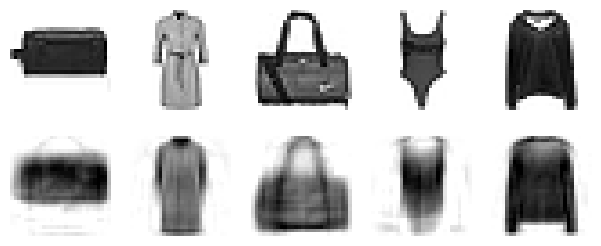

In [ ]:
def plot_reconstructions(model, images=X_valid, n_images=5, origin = 0):

    n_images = n_images if (origin + n_images) < images.shape[0] else max(1,images.shape[0]-origin)
    reconstructions = np.clip(model.predict(images[origin:origin + n_images]), 0, 1)
    
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[origin + image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(stacked_ae, origin = np.random.randint(0,X_valid.shape[0]))

plt.show()

Hmmm, la compresión es "mala", pero veamos que pasa si proyectamos las 30 nuevas dimensiones en 2 (ojo, no vamos a usar PCA sino otra aproximación, t-SNE, que viene de perlas para pintar cluster de alta dimensión... vaya, ya nos lo podrías haber dicho antes :'-) ), y pintamos los clusters creados:

In [13]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 1ms/step


Exception in thread Thread-6:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\tf_gpu_env\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\ProgramData\Anaconda3\envs\tf_gpu_env\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\ProgramData\Anaconda3\envs\tf_gpu_env\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "c:\ProgramData\Anaconda3\envs\tf_gpu_env\lib\subprocess.py", line 1495, in _readerthread
    buffer.append(fh.read())
  File "c:\ProgramData\Anaconda3\envs\tf_gpu_env\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x99 in position 27: invalid start byte
c:\ProgramData\Anaconda3\envs\tf_gpu_env\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the

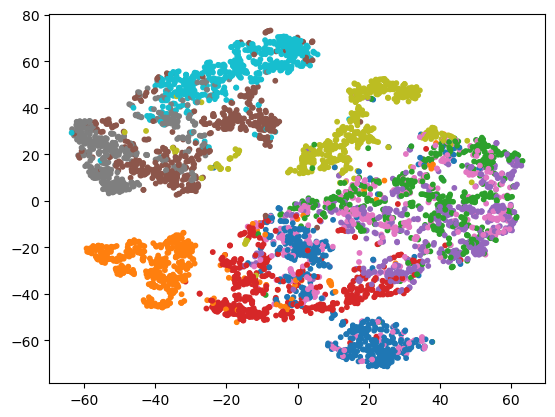

In [14]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

Y esto de regalo (adaptado de Aurelien Geron que a su vez lo adapta de los [ejemplos de sklearn](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html)

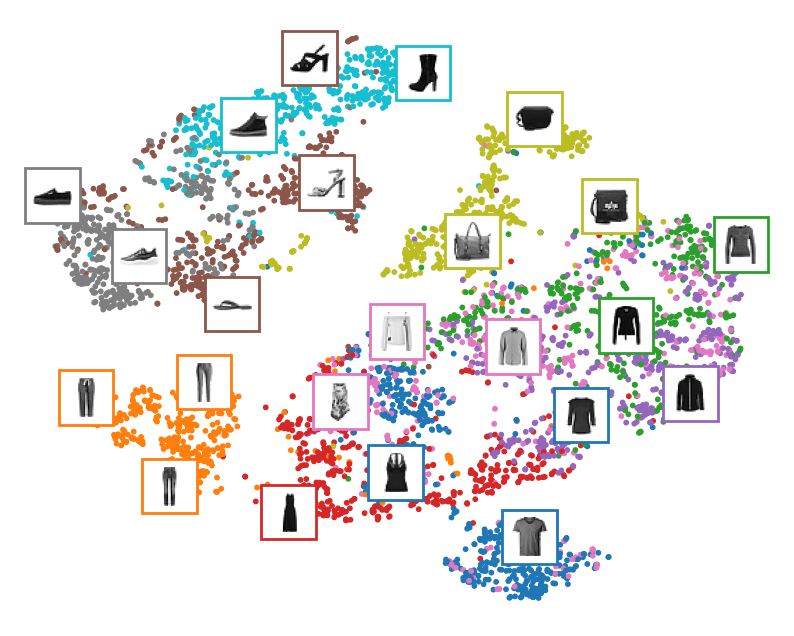

In [15]:
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

### Evolución de los Autoencoders

Los autoencoders han evolucionado desde el modelo sencillo (también llamado stacked, porque hay varias capas en encoder y decoder) hasta los VAE (Variational Autoencoders), y de por medio han aparecido los convolucionales que usan capas convolucionales.  

Estas dos variantes, los VAE y el uso de capas convolucionales están detrás de los dos grandes saltos dentro de la generativa de imágenes.  

Empezando por los **VAE**, muy resumidamente, introducen un truco que es que lo que alimenta al decoder no es directamente la salida de las neuronas del encoder sino que a partir de una salida se genera otra que se fuerza a que pertenezca a una distribución gaussiana con la anterior (¿cómo dices?). Es como si al introducirle una imagen le estuviéramos diciendo que no es esa imagen sino un prototipo de imagen y que aprenda variantes de la misma. 

Luego podemos separar el decoder y e introducirle entradas aleatorias (que sigan una distribución gaussiana) y será capaz de inventarse imágenes con cierto sentido.


Por otro lado, se puede construir un Autoencoder con **capas convolucionales a la entrada del encoder**, pero para poder invertir las capas y hacer una construcción simétrica **en el decoder, es necesario usar unas capas denominadas capas convolucionales transpuestas**. Y en cuanto tuvimos esta circunstancia a alguien se le ocurrió poner a competir a dos autoencoders y nacieron las GAN.  


Para entender un poco más los GAN sólo un inciso, las capas convolucionales transpuestas, son capas que reciben la salida de otras capas convolucionales y devuelven la salida de sus filtros con la resolución de entrada a esas otras capas convolucionales

<img src="https://github.com/rodolso/DS_Online_Octubre24/blob/main/05_Deep_Learning/Sprint_19/Unidad_01_IA_Generativa_Imagenes/img/transposed_Deconvolution.webp?raw=1" alt="Inversa y Transpuesta de una convolucional" height="200"/>

En un autoencoder, si en el encoder (Conv2D) hay convolucionales en el decoder hay transpuestas (Conv2DTranspose)

## GANs

Son dos redes neuronales con misiones contrapuestas. Una (la denominada Generator) tiene como objetivo crear instancias falsas o sintéticas que la otra (denominada Discriminator) debe clasificar como verdaderas, mientras que la misión del Discriminator es la de aprender cuáles son las falsas.  

<img src="https://github.com/rodolso/DS_Online_Octubre24/blob/main/05_Deep_Learning/Sprint_19/Unidad_01_IA_Generativa_Imagenes/img/GAN.jpg?raw=1" alt="Diagrama sencillo GAN" width="1000"/>

Para entenderlas un poco mejor, merece la pena conocer cómo se entrenan (porque no es cómo en las redes vistas hasta ahora):  

1. Primero al batch de imágenes reales se le añade otro batch de imágenes falsas. Estas imágenes falsas se crean metiendo ruido gaussiano (tiramos muchas veces un gran dado "especial" que sigue una distribución estadística gaussiana, las caras del dado no tienen las mismas probabilidades de salir :-)). Tiramos tantas veces nuestro "dado gaussiano" como "features" (llamadas codings) queramos darle de comer. Nuestro Generador creará tantas imágenes como haga falta haciendo pasar la entrada aleatoria por sus capas (sí, claro, las primeras veces será un manchurrón porque los pesos del Generador no están entrenados) y las mezclamos con el batch de imágenes reales.  

2. A las imágenes reales les asignamos la clase 1, por ejemplo, y a las falsas la clase 0. Ahora entrenamos sólo el Discriminador (que las primeras veces lo tendrá chupao).  

3. "Congelamos" el discriminador (es decir evitamos que sus capas sean entrenadas en la siguiente parte)  

4. Ahora sí, usamos toda la red Generator seguido de Discriminator para entrenar (pero como hemos hecho 3. sólo se entrenará el Generator, ingenioso, eh?)  

5. Y, ¿cómo? Pasamos otras "tiradas de dados" como entradas (si pasasemos las mismas que en 1 y 2 entonces el Discriminator tendría ventaja que ya las ha visto con su etiqueta de verdad), el Generator, generará las mismas imágenes fake, pero a estas las etiquetamos como reales y las pasamos por el Discriminator. Ahora cada vez que el Discriminator diga que es fake (mucho al principio) los pesos de las capas del Generator se irán configurando para poder engañar al Discriminator.

Y voilá, veámoslo con código

This project requires Python 3.7 or above:

# Generative Adversarial Networks

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 30 # size of the noise vector (latent space)

# Creamos un modelo para el discriminador y un modelo para el generador. Una vez entrenado este último nos permitirá crear caras (eso sí, de forma aleatoria, no podremos guiar el proceso)
generator = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[codings_size]),
    tf.keras.layers.Dense(100, activation="selu"), # selu es una función de activación que se comporta mejor que relu en algunos casos
    tf.keras.layers.Dense(150, activation="selu"),
    tf.keras.layers.Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28]) # Convertimos la salida del generador en "imágenes" de 28x28
])

discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[28, 28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150, activation="selu"),
    tf.keras.layers.Dense(100, activation="selu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

gan = tf.keras.models.Sequential([generator, discriminator])

In [17]:
# Primer truco para entrenar, creamos un modelo para el discriminador y un modelo con generador y discriminador, las capas del discriminador las "congelaremos" para entrenar el generador
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [18]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [18]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    training_time = []
    
    generator, discriminator = gan.layers
    
    for epoch in range(n_epochs):
        epoch_t_zero = time()
        print(f"Epoch {epoch + 1}/{n_epochs}")  # extra code        
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size]) # Generamos unas tiradas de dados para hacer las imágenes falsas
            generated_images = generator(noise) # Generamos las imágenes fake pasándolas por el Generator tal cual esté en ese momento, (a medida que se vayan generando batches irá mejorando)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0) # Mezclamos falsas (generated_images) y reales (X_batch)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) # Asignamos 0 a las falsas y 1 a las reales
            discriminator.trainable = True # Descongelamos los pesos del discriminador
            discriminator.train_on_batch(X_fake_and_real, y1) # Entrenamos, utilizando el método especial de entrenar en un sólo batch y aprovechamos que los modelos se entrenan progresivamente :-), no se pierden los pesos al volver a entrenar
            
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size]) # Nuevas tiradas para no dar ventaja al Discriminator, y que serán la entrada a toda la GAN
            y2 = tf.constant([[1.]] * batch_size) # Preparamos la trampa para el Discriminator, le vamos a decir que todas son reales (por eso tenemos que congelar los pesos del Discriminator sino aprendería a decir que sí a todas las imágenes fake)
            discriminator.trainable = False  # Congelamos los pesos del discriminador para entrenar el generador
            gan.train_on_batch(noise, y2) # Utilizamos el modelo GAN, que en realidad sólo está entrenando las capas del Generator
        
        # extra code — plot images during training
        training_time.append(time() - epoch_t_zero)
        plot_multiple_images(generated_images.numpy(), 8) # Para ver como el Generator va mejorando
        clear_output(wait = True)
        print("Dur epoca:", training_time[-1])
        plt.show()
    
    print("Duracion entrenamiento:", np.sum(training_time))

Dur epoca: 63.21701622009277


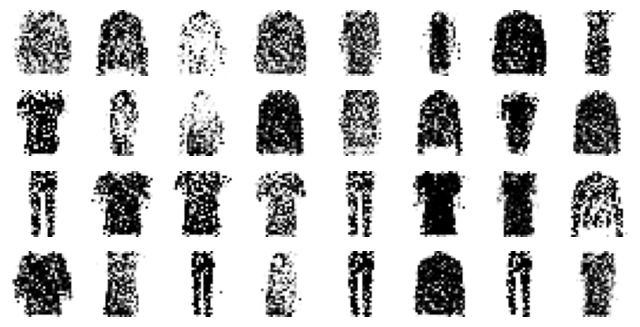

Duracion entrenamiento: 619.5203852653503


In [21]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

Y ahora que ya lo hemos entrenado, juguemos un poco

In [22]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

1/1 [==============================] - 0s 41ms/step


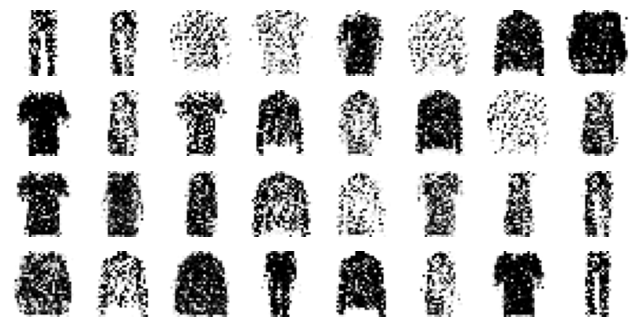

In [ ]:
# extra code – this cell generates and saves Figure 17–15
plot_multiple_images(generated_images, 8)
#save_fig("gan_generated_images_plot", tight_layout=False)
plt.show()

## Evolución de las GAN: StyleGANs

__Deep Convolutional GANs (DCGAN)__: Las GAN que hemos visto usan capas densas, lo siguiente fue incluir capas Convolucionales Transpuestas en el Generator y Convolucionales al Discriminator y hacer algunos truquis para que el entrenamiento fuera estable (no se llegaran a "acuerdos" entre Discriminator y Generator, como, por ejemplo, lo que se conoce como Mode Collapse).  

__Progressive DCGAN__: En 2018, ese año, los investigadores de Nvidia introdujeron nuevas mejoras, siendo la principal la arquitectura de la red es dinámica en entrenamiento (se van añadiendo capas convolucionales a medida que se entrena) y otros elementos para hacerla estable.

__StyleGANs__: No mucho después, introdujeron cambios que dieron un salto cualitativo destacado. Básicamente cambiaron la arquitectura del Generator de forma que ahora tenía a su vez dos partes: Mapping Network y Synthesis Network (ambas entrenables)



<img src="https://github.com/rodolso/DS_Online_Octubre24/blob/main/05_Deep_Learning/Sprint_19/Unidad_01_IA_Generativa_Imagenes/img/styleGAN.webp?raw=1" drawing = "Diagrama de un Generator de una StyleGAN" width ="600" />

Lo diferencial, es que la mapping network es como un superembedding de las imágenes (Creado antes de sintetizar las imágenes) que da un vector por imagen (w, también style vector) base y luego este vector se pasa por las capas de transformación (A) que generan otros subvectores que ya sí entran el módulo de _synthesis_ que genera la imagen aleatoria.  

Lo potente además de que se generen imágenes cada vez más realistas es que una vez entrenado este Generator, se pueden tocar las cajas A y sobre una misma imagen generada podemos cambiar las características (el color del pelo, la edad, el humor, etc). De hecho también podemos cambiar la imagen de partida tocando el vector w.
  
Lo que no podemos así tal cual es tocar foto que no haya sido generada por el sistema (tened en cuenta que se le dan tiradas aleatorias de dados para comer). Por supuesto hay aplicaciones que son capaces de sacar el vector w de una imagen dada y luego aplicar una red de synthesis preentrenadas.


* [Alquileres](https://thisrentaldoesnotexist.com)
* [Caras](https://thispersondoesnotexist.com)
* [Which Face is Real](http://www.whichfaceisreal.com/)

# Diffusion Models

Muy resumidamente, los modelos de difusión (no son GAN), son redes a las que se les pasa como entrenamiento imágenes a las que se les ha aplicado ruido de forma progresiva (a cada pixel se le ha ido añadiendo un número aleatorio pequeñito progresivamente) y el ruido. La red aprende que dada una imagen con ruido, cuál es el ruido.  

Posteriormente, para predecir, se le da al modelo un ruido inicial aleatorio (habitualmente es ruido Gaussiano o normal, lo importante es que nunca hubo imagen), pero no se le indica que sea así y la red predice el que cree que sería el ruido de haber una imagen real detrás, y vamos quitando capas y sale la imagen (_hallucinated_ que se dice técnicamente) a la que habríamos tenido que añadir el ruido que ha "supuesto" la red para que saliera el ruido inicial.  

El proceso sería algo así:

- Imagen_X + un poco de ruido -> Imagen_1 (la red tiene que aprender el "poco de ruido")  

- Imagen1 + otro poco de ruido -> Imagen_2 (la red tiene que aprender el "otro poco de ruido")
  
- Imagen2 + más poco ruido -> Imagen_3 (la red tiene que aprender "más poco ruido")  

- ...

- ...

- ...

- Imagen3999 + poquito final de ruido -> Imagen4000  (que ahora será un buen manchurrón de ruido completo, indistinguible para el ojo humano) -> la red tiene que aprender "poquito final de ruido".

<img src="https://github.com/rodolso/DS_Online_Octubre24/blob/main/05_Deep_Learning/Sprint_19/Unidad_01_IA_Generativa_Imagenes/img/diffusion_forward.png?raw=1" alt ="Proceso forward de diffusion" width = "800"/>

Si hacemos esto con millones de imágenes, el modelo estará preparado para:

- Dado un supermanchurrón de ruido (sin ninguna imagen detrás), hacemos model.predict(Supermanchurrón) -> poquito_final (la red predice aunque no tenga sentido)  

- Supermanchurrón menos un poquito_final -> model.predict(Supermanchurrón-un_poquito_final) -> un poquito menos de manchurrón  

- Supermanchurrón - un poquito_final - un poquito menos de manchurrón -> model.predict...  

- ...  

- Supermanchurrón sin todos los 4000 predict manchurroncitos -> Lo que sea que pueda salir de ahí, pero siempre en el espacio latente de las imágenes que le he dado es decir una combinación de las imágenes de partida -> MAGIA!!!

<img src="https://github.com/Jaimegrp/Practicando/blob/main/img/denoising_diffusion.jpg?raw=1" alt = "Proces de quitar ruido en Diffusion" width = "800"/>

### Diffusion Models y Aprendizaje Condicional

Además a estos sistemas se les ha añadido entrenamiento con aprendizaje condicional. Básicamente el aprendizaje condicional se da cuando a nuestro dataset de entrada le añadimos "condiciones" (features extra).  

Un ejemplo destacado es Stable Diffusion, que desde su lanzamiento en 2022 ha evolucionado a través de varias versiones (como Stable Diffusion XL y Stable Diffusion 3 en 2023-2024). Estos modelos han sido entrenados con millones y millones de imágenes a las que se ha condicionado con un texto descriptivo, mejorando progresivamente la calidad y fidelidad de las imágenes generadas.  

A la hora de entrenar a la imagen además de añadir el ruido se le añade una "vectorización" del texto de caption (algo así como su embedding) de forma que a la hora de hacer el denoising la red no "intuye" el poquito de manchurrón que tiene la imagen, sino el poquito de manchurrón condicionado al texto que se le dé de entrada.  

Para saber más (jugando con ello, que ya podéis perfectamente)


https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/

https://keras.io/examples/generative/finetune_stable_diffusion/

*NOTA: El finetune de Keras no funciona directamente porque el dataset, dibujos de Pokemon con descripción, tuvieron que cerrarlo a petición de los dueños de los derechos... El script sí funciona, pero necesitas alimentarlo con una buena panda de imágenes proporcionadas por ti*

BONUS: Deep Convolutional GAN (DCGAN)

In [12]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 100

generator = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[codings_size]),
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="selu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                 activation="tanh"),
])
discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[28, 28, 1]),
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

gan = tf.keras.models.Sequential([generator, discriminator])

In [13]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [14]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1 # Necesario porque el generador tiene una tanh (-1,1) como función de activación

In [15]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [21]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

: 

## Extra: Tendencias recientes en IA Generativa para Imágenes  



Desde la redacción original de este documento, han surgido varias arquitecturas y enfoques que han llevado la generación de imágenes a nuevos niveles:

### Modelos Multimodales

Los modelos multimodales como CLIP (_Contrastive Language-Image Pre-training_) de OpenAI han revolucionado la forma en que los modelos comprenden la relación entre texto e imágenes.  

CLIP fue entrenado con 400 millones de pares de imágenes y texto, aprendiendo a asociar descripciones textuales con contenido visual. Esta capacidad ha sido fundamental para mejorar los modelos de difusión condicionados por texto.

### Arquitecturas Transformer para Imágenes

Las arquitecturas Transformer (originalmente diseñadas para NLP) han demostrado ser extremadamente efectivas también para imágenes:

- **ViT (Vision Transformer)**: Divide las imágenes en parches y los trata como "tokens" de manera similar a las palabras en NLP.  

- **Swin Transformer**: Introduce ventanas deslizantes jerárquicas para capturar mejor las dependencias locales y globales en imágenes.

Estas arquitecturas han mejorado significativamente la calidad de los modelos generativos al proporcionar mejores representaciones de las imágenes.

### Nuevos Avances en Modelos de Difusión

- **Diffusion Transformers (DiT)**: Combinan la arquitectura Transformer con el proceso de difusión, mejorando la coherencia global de las imágenes generadas.  

- **Latent Diffusion Models (LDM)**: Operan en el espacio latente en lugar del espacio de píxeles, reduciendo significativamente los requisitos computacionales mientras mantienen la calidad.  

- **Consistency Models**: Reducen drásticamente el número de pasos necesarios para la generación, acelerando el proceso sin sacrificar calidad.

### Modelos Text-to-Video

- **Sora** de OpenAI: Capaz de generar videos de alta calidad y larga duración a partir de descripciones textuales.  

- **Gen-2** de Runway: Permite generar videos a partir de texto, imágenes o incluso otros videos.

Estos modelos aplican conceptos similares a los modelos de difusión para imágenes, pero extendidos a la dimensión temporal.

### Edición y Control Preciso

Nuevas técnicas que permiten un control más preciso sobre la generación:

- **ControlNet**: Permite guiar la generación mediante condiciones adicionales como mapas de profundidad, poses humanas o bocetos.  

- **Inpainting y Outpainting**: Técnicas mejoradas para editar partes específicas de una imagen o expandir sus límites.  

- **IP-Adapter**: Permite incorporar referencias visuales específicas en el proceso de generación.

